# Unstructured Data Analytics - Group Assignment 1
# Analyzing Car Brand Data Scraped from Edmunds.com

Created by: Aman Bhardwaj, Blake DeLong, Apurva Harsulkar, Colby Meline, Joel Nail, and Rahul Rangarao

As analytics consultants to JD Power and Associates, we needed to perform a competitive analysis on entry level car market
In conventional analytics, we'd look at dealership level data, sales data from car brands, and/or information from user surveys.

However we don't think that's a treasure trove of information relative to what customers actually "feel, discuss, and aspire for"

Edmunds is a popular car review/discussion website used by car enthuasists to post their opinions, discuss about cars, and look at reviews
In order to obtain data represenative of this population, we decided to scrape data from their entry level luxury forum: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans



#

First, we need to scrape the messages from the forum. We have comments from users from 2020 going back to 2014, we are just using 5000 comments 

In [27]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
import pandas as pd

# Setup Firefox
firefox_options = Options()
firefox_options.headless = True
driver = webdriver.Firefox(options=firefox_options)
# page = 435
data = {"datetime": [], "message": []}


# Get page from page list
def edmunds(p):
    global driver
    driver.get(
        "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}".format(p))


def get_messages():
    global data
    global driver
    times = driver.find_elements(By.XPATH, '//span[@class="MItem DateCreated"]')
    messages = driver.find_elements(By.XPATH, '//div[@class="Message userContent"]')
    for dt, message in zip(times, messages):
        dtval = dt.find_element(By.XPATH, './/time').get_attribute("datetime")
        messageval = message.text
        data["datetime"].append(dtval)
        data["message"].append(messageval)


def get_pages(pages):
    for p in range(pages, pages - 20, -1):
        edmunds(p)
        get_messages()
    driver.quit()


def get_data(num, start=435):
    while len(data["datetime"]) < num:
        edmunds(start)
        get_messages()
        start -= 1
        print("{} Records Collected; {} Remaining".format(len(data["datetime"]), num-len(data["datetime"])))
    driver.quit()

def pd_to_csv():
    global data
    df = pd.DataFrame(data)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df.to_csv("edmunds.csv")

pd_to_csv()

Importing relevant libraries

In [3]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns

#nltk.download()

[nltk_data] Downloading package punkt to /Users/joelnail/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Since we have already scraped the data, we're just reading the csv file created

In [4]:
edmunds = pd.read_csv("edmunds.csv", index_col=0)
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

### A. Testing Zipf's Law for top 100 words

In [5]:
#word_count_zipf's Law
website = re.compile("(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+")  ###Removes URLS
word_freq={}
for i in edmunds.iloc[:,1]:
    i=str(i)
    urls = set(re.findall(website, i)) 
    for url in urls:
        i = i.replace(url, "")
    i=i.lower()
    i=word_tokenize(str(i))
    for word in i:
        if word not in word_freq:
            word_freq[word]=1
        else:
            word_freq[word]+=1

freq_df=pd.DataFrame({"word": [i for i in word_freq.keys()], "frequency": [i for i in word_freq.values()]})
freq_df=freq_df.sort_values(by='frequency',ascending=False)
top100=freq_df.reset_index().drop('index',axis=1).head(100)
top100.index+=1

In [6]:
#Running Linear Regression on all of the data to ‘econometrically’ prove the data follows Zipf’s Law
proof_df = freq_df.reset_index().drop('index',axis=1)
proof_df.index+=1
y_p = proof_df.frequency.values
x_p = proof_df.index.values
x_p = np.log(x_p)
y_p = np.log(y_p)
lr=LinearRegression()
lr.fit(x_p.reshape(-1,1),y_p)
print(lr.coef_)

[-1.40172669]


In [7]:
y=top100.frequency.values
X=top100.index.values
X=np.log(X)
y=np.log(y)

lr=LinearRegression()
lr.fit(X.reshape(-1,1),y)

LinearRegression()

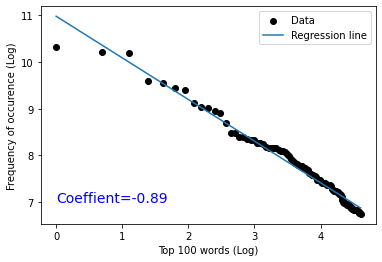

In [8]:
plt.scatter(X,y,label='Data',color='black')
plt.plot(X,lr.predict(X.reshape(-1,1)),label='Regression line')
plt.xlabel("Top 100 words (Log)")
plt.ylabel("Frequency of occurence (Log)")
plt.text(x=0,y=7,s=r"Coeffient="+str(round(lr.coef_[0],2)), fontsize=14, color="b")
plt.legend()

Since the linear coefficent is near -1, it tells us the frequency is inversely proportional to the rank of the word. i.e higher the rank, higher the frequency of occurence

### Mapping cars to car brands and removing stop words and punctuations

In [6]:
brands_cars=pd.read_csv("modelsbrandsPlusLexus.csv")  ####We're adding additional car brands not in list (Ex: Lexus)
brands_cars.replace({'Brand':{'volkwagen':'volkswagen',\
                            'hyndai kia':'hyundai',
                            'hyundai.':'hyundai',
                            'hyundai,':'hyundai',
                            'kia,':'kia',
                            'kia.':'kia',
                            'mercedes benz':'mercedes',
                            'mercedes-benz':'mercedes',
                            'nissan.':'nissan',
                            'toyata':'toyota','acura':'accura'
                    }},inplace=True)
brand_car_map=dict(zip(brands_cars.Model,brands_cars.Brand))
brand_car_map.update({'gt2':'kia','elon':'tesla','model 3':'tesla','model y':'tesla','tlx':'accura','cts':'cadillac',\
                    '2-series':'bmw','merc':'mercedes','320i':'bmw','x2':'bmw','x1':'bmw','x3':'bmw','m3':'bmw',
                    'Mazdaspeed':'mazda','cr-v':'honda','e63':'mercedes','GLA45':'mercedes','xt4':'cadillac','q2':'audi',
                    '5 series':'bmw','3 series':'bmw'
                    })

def lookup(word, bank):
    if word in bank:
        return bank[word]
    return word
all_words = {}  
new_df = {"datetime": [], "message": []}
aspDF = {"datetime": [], "message": []}


Now we're iterating through the individual comments and mapping car models to brands (ex: jetta -> volkswagen, q3 -> audi etc.) 

In [7]:

for i, row in edmunds.iterrows():
    d = row["datetime"]
    message = row["message"]
    if isinstance(message, str):        ###Below set of code is to replace 
        urls = set(re.findall(website, message)) 
        for url in urls:
            message = message.replace(url, "")
        message = message.replace("/", " ")
        message=message.lower()
        m1=message
        try:
            message = word_tokenize(message)
        except:
            nltk.download('punkt')
            message = word_tokenize(message)
        m1=[lookup(str.strip(word), brand_car_map) for word in message]
        message = [lookup(str.strip(word), brand_car_map) for word in message if word not in stop_words]
        message = " ".join(message)
        m1 = " ".join(m1)

        new_df["datetime"].append(d)
        new_df["message"].append(message)

        aspDF["datetime"].append(d)
        aspDF["message"].append(m1)
        
        words=word_tokenize(message)
        for word in words:
            if word not in all_words:
                all_words[word]=1
            else:
                all_words[word]+=1

new_df = pd.DataFrame(new_df)
aspDF = pd.DataFrame(aspDF)
#new_df.to_csv("filtered_edmunds.csv")

Creating a dictionary to connect brands to their frequency

In [8]:
cars_freq={}
for key,value in all_words.items():
    if(key in list(brand_car_map.values()) and key!='car' and key!='seat'):
        cars_freq.update({key:value})

# B. The top 10 car brands are:

In [9]:
cars_freq={k: v for k, v in sorted(cars_freq.items(), key=lambda item: item[1])[::-1]}

#print(cars_freq)

cars_freq_df = pd.DataFrame.from_dict(cars_freq, orient="index")
cars_freq_df.columns = ["Frequency"]
cars_freq_df.head(10)

,Frequency
bmw,2996
audi,2658
accura,1267
honda,1042
cadillac,802
volkswagen,621
infiniti,473
lexus,455
mercedes,450
hyundai,447


In [10]:
top_10=[]
for key,val in enumerate(cars_freq):
    top_10.append(val)
    if(key==9):
        break

In [11]:
def calc_lift(brand1,brand2):
    a_b=0
    n_a=0
    n_b=0
    if(brand1==brand2):
        return np.nan
    for i in new_df['message']:
        words=word_tokenize(i)
        a=set(words).intersection(set({brand1,brand2}))
        if(len(a)==2):
            a_b+=1
            n_a+=1
            n_b+=1
        elif(len(a)==1):
            if(a.pop()==brand1):
                n_a+=1
            else:
                n_b+=1                
    return a_b/(n_a*n_b)*len(new_df)

# C. Calculating Brand lift between the cars

In [12]:
brand_lift=[]
for i in range(0,len(top_10)):
    brand1=top_10[i]
    lst=[]
    for j in range(0,len(top_10)):
        if(j<i):
            lst.append(np.nan)
        else:
            brand2=top_10[j]
            lst.append(calc_lift(brand1,brand2))
    brand_lift.append(lst)
brand_lift=pd.DataFrame(brand_lift)
#brand_lift=brand_lift.drop(index="sedan")
#brand_lift=brand_lift.drop(axis=1, columns="sedan")
#brand_lift
brand_lift.index=top_10
brand_lift.columns=top_10

Table of lift values

In [48]:
b=(brand_lift.replace(np.nan,0)+brand_lift.T.replace(np.nan,0))
b

,bmw,audi,accura,honda,cadillac,volkswagen,infiniti,lexus,mercedes,hyundai
bmw,0.000000,1.763053,0.945919,1.160991,1.714940,1.060029,1.828096,2.002409,2.595570,1.219689
audi,1.763053,0.000000,1.597266,1.611888,2.381856,2.565869,2.683594,2.636177,3.148675,1.681903
accura,0.945919,1.597266,0.000000,3.315497,1.245770,0.913290,2.748320,2.250892,1.626112,1.017185
honda,1.160991,1.611888,3.315497,0.000000,1.089235,2.045021,1.988533,2.264859,1.700541,2.127485
cadillac,1.714940,2.381856,1.245770,1.089235,0.000000,0.947693,2.764546,3.712653,4.079347,1.565854
volkswagen,1.060029,2.565869,0.913290,2.045021,0.947693,0.000000,1.244479,1.205858,1.416013,2.125828
infiniti,1.828096,2.683594,2.748320,1.988533,2.764546,1.244479,0.000000,6.294736,3.956775,2.741637
lexus,2.002409,2.636177,2.250892,2.264859,3.712653,1.205858,6.294736,0.000000,5.190617,3.099310
mercedes,2.595570,3.148675,1.626112,1.700541,4.079347,1.416013,3.956775,5.190617,0.000000,1.892517
hyundai,1.219689,1.681903,1.017185,2.127485,1.565854,2.125828,2.741637,3.099310,1.892517,0.000000


Plotting the lift ratios, we've intentionally kept the diagional as null  

<AxesSubplot:>

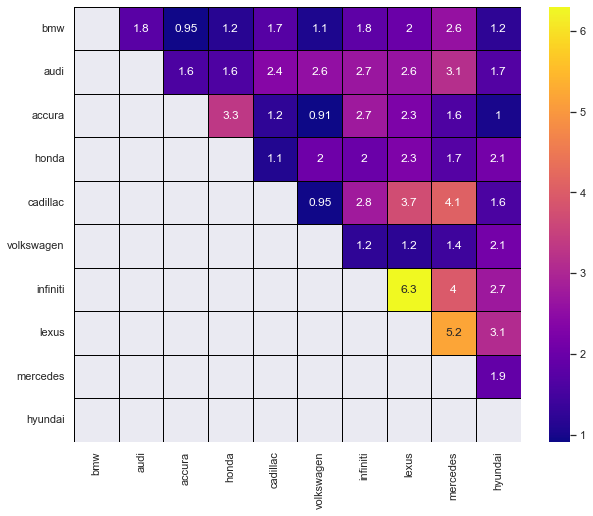

In [20]:
sns.set(rc={'figure.figsize':(10, 8)})

sns.heatmap(brand_lift,annot = True, cmap ='plasma',
            linecolor ='black', linewidths = 1 )

In [28]:
brand_similarity_matrix=(brand_lift.replace(np.nan,0)+brand_lift.T.replace(np.nan,0))

# D. Getting the MDS Plot for Dissimilarity

In [29]:
brand_dissimilarity = brand_similarity_matrix.apply(lambda x: 1/x)
#b.apply(lambda x: 1/x)
brand_dissimilarity.replace([np.inf, -np.inf], 0, inplace=True)

In [30]:
# code modified from GitHub user zack-tan's music lyric analysis project
# creates a metric mds plot with annotations 
def mdsplot_generator(brand_lift_df):
    from sklearn.manifold import MDS
    mds = MDS(n_components=2)
    brand_df_transformed = mds.fit_transform(brand_lift_df)
    brand_df_transformed.shape

    mds_df = pd.DataFrame(brand_df_transformed)
    mds_df['brand'] = list(brand_lift_df.columns)
    mds_df.columns = ['component0', 'component1', 'brand']

    import matplotlib.pyplot as plt
    from scipy.spatial import ConvexHull
    import numpy as np

    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, figsize=(8,8))

        # plot data
        x = mds_df.component0
        y = mds_df.component1
        plt.scatter(x, y, s=100)
        
        n = mds_df.brand
        for i, txt in enumerate(n):
            ax.annotate(txt, (x[i], y[i]))

/Users/joelnail/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


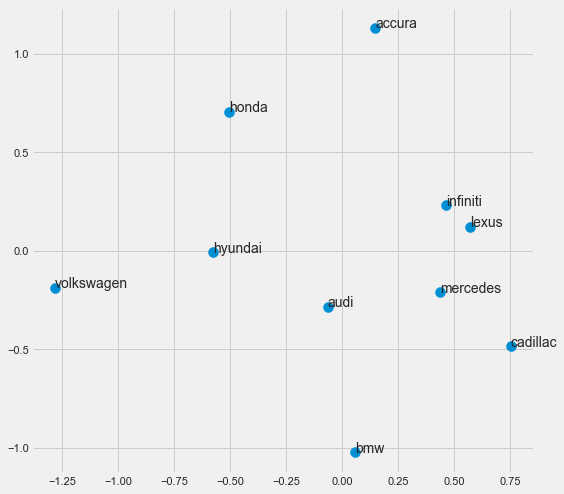

In [31]:
mdsplot_generator(brand_dissimilarity)

# E.  MDS Plot Observations and Insights

##### 1. The MDS plot above displays two distinct clusters: luxury (Mercedes, Cadillac, etc.) and non-luxury (Honda, Volkwagen, etc.)
##### 2. The tightly-clustered luxury brands (Infiniti, Lexus, etc.) in the MDS plot are frequently compared with each other but not as often against non-luxury brands. On the other hand, Audi is located closer to the center of the plot due to it's fairly high lift values with the majority of brands. Based on this finding, we would recommend that Audi target non-luxury car owners as they are more likely to switch to Audi than other luxury brands. Meanwhile, we would suggest that brands like Infiniti and Lexus should target fellow luxury car owners as potential "switchers"
##### 3. Despite BMW being the most frequently mentioned brand, BMW does not have high lift values with most other brands which is why they are fairly isolated in the MDS plot. This suggests that although people talk about BMW a lot, they don't frequently compare BMW with other brands. Based on this finding, we would recommend that BMW focus on unique advertising that distinguishes itself from other luxury brands i.e., doesn't try to show how BMW is "better" - doing so will further the perception of BMW being in "a league of its own"
##### 4. Although considered a luxury brand, Accura is not compared against other luxury brands as much as it is compared to its non-luxury sister brand, Honda. Based on this finding, we would recommend that Accura target current Honda customers as they are most likely to switch to Accura. This strategy could be complemented by further data analysis in order to find customers who have recently experienced an increase in income/wealth. In this same vein, adding in other non-luxury sister brands (e.g., Nissan for Infiniti, Toyota for Lexus) might provide interesting insights for those brands

# F. Popular attributes for brands 
After looking through the data in excel for easier formatting, we isolated the below list of words as the most common attributes as:
"Luxury","Performance","Premium","Sport" and "Power"

In [32]:
# after looking through the data in excel for easier formatting, we isolated the below list of words as the most common attributes
attrib_list = ["luxury", "performance", "premium", "sport", "power"]

all_words_df = pd.DataFrame.from_dict(all_words, orient="index", columns=["Frequency"] )
all_words_df = all_words_df.reset_index()
all_words_df = all_words_df.rename(columns= {"index" : "Word", "Frequency" : "Frequency"})
all_words_df = all_words_df.sort_values(by="Frequency", ascending=False)
all_words_df[all_words_df["Word"].isin(attrib_list)].set_index('Word')

,Frequency
Word,
sport,599
luxury,528
performance,516
power,384
premium,337


In [33]:
attrib_list = ["luxury", "performance", "premium", "sport", "power"]

attr_lift=[]
for i in range(0,len(top_10)):
    brand1=top_10[i]
    lst=[]
    for j in range(0,len(attrib_list)):
        attrib=attrib_list[j]
        lst.append(calc_lift(brand1,attrib))
    attr_lift.append(lst)

In [38]:
attr=pd.DataFrame(attr_lift)
attr.columns=attrib_list
attr.index=top_10

<AxesSubplot:>

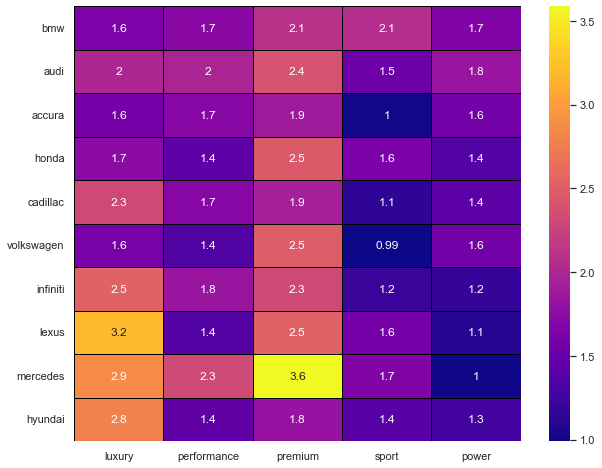

In [39]:
sns.heatmap(attr,annot = True, cmap ='plasma',
            linecolor ='black', linewidths = 1)

The 5 most frequently mentioned attributes/features are luxury, performance, sport, power and 
premium:
Luxury 528
Performance 516
Power 384
Premium 337
Speed 242
Lexus is most associated with luxury with a lift of 3.2
Mercedes is most associated with performance with a lift of 2.3
Mercedes is most associated with premium with a lift of 3.6
BMW is most associated with sport with a lift of 2.1
Audi is most associated with power with a lift of 1.8 and BMW is a close second with 1.7

# G.  Our advice to companies
From our Dissimilairy matrix we have two categories of competitors in this market. Audi, BMW,
Mercedes, Cadilac, infiniti and Lexus are one perceived category while Toyota, Hyundai, honda 
and acura are in one category of competitors. 

BMW's current slogan is "sheer driving pleasure" which aims to hit the “luxury” and “premium” 
attributes in our chosen list of attributes. When we compare the lift values for attribute 
associations BMW underperforms with a lift of 1.6 in luxury. Other brands have higher lift 
values for luxury meaning people do not associate the brand value of BMW with luxury as much
as other brands. BMW’s association lift value with premium is also average at 2.1. Competitors 
have edged out BMW on this scale. BMW’s most challenging competitor is Mercedes and Lexus
which lead the attribute association in both categories. We would recommend BMW to tweak 
their design so their vehicles are associated more with luxury and premium to match their slogan.

Volkswagen has underperformed in attribute association of “sport”. The lift value of association 
with sport is below 0 at 0.99. Meaning users rarely associate Volkswagen with “Sport”. It’s 
competitors per the dissimilarity matrix, Honda and Hyundai, beat Volkswagen in this category. 
While at the same time Volkswagen beats Honda and Hyundai in attribute association with 
“power” and matches the two in association with “performance”. So users do associate 
Volkswagen more with power but at the same time they do not associate it with “Sport”. We 
would recommend Volkswagen to update their vehicle design to be sportier to improve user 
perception of Volkswagen cars with “sportiness” as compared to its competitors.

# H. Aspirational brands:

We decided to do a Brand to Aspiration Lift Analysis. We took the raw reviews with stop words 
included and replaced several phrases which indicate aspiration with the word “aspiration”. For 
example, a review could read “I wish to drive a BMW 7 series one day” and we can replace the 
phrase “wish to” with “aspiration”. 


In [40]:
aspirational_list={'wish to':'aspiration','hope to':'aspiration','would love to':'aspiration',
                   'dream of':'aspiration','my dream car':'aspiration','my ideal car':'aspiration',
                   'yearn to':'aspiration','my wish':'aspiration'}

In [41]:
#aspire_df=new_df.copy()
for key,value in aspirational_list.items():
    for i in range(0,len(aspDF)):
        aspDF.loc[:,'message'][i]=str(aspDF.loc[:,'message'][i]).replace(key,value)

Calculating lift of brands with aspiration

In [42]:
def calc_aspire_lift(brand1):
    a_b=0
    n_a=0
    n_b=0
    for i in aspDF['message']:
        words=word_tokenize(i)
        a=set(words).intersection(set({brand1,"aspiration"}))
        if(len(a)==2):
            a_b+=1
            n_a+=1
            n_b+=1
        elif(len(a)==1):
            if(a.pop()==brand1):
                n_a+=1
            else:
                n_b+=1                
    return a_b/(n_a*n_b)*len(new_df)

lst=[]
for i in range(0,len(top_10)):
    brand1=top_10[i]
    lst.append(calc_aspire_lift(brand1))

In [43]:
aspirational_lift=pd.DataFrame(lst)
aspirational_lift.index=top_10
aspirational_lift.columns=['Aspiration']

In [46]:
aspirational_lift.sort_values(by='Aspiration',ascending=False)

,Aspiration
cadillac,2.650030
infiniti,1.988533
mercedes,1.900605
audi,1.878002
hyundai,1.783333
bmw,1.757813
honda,1.633853
lexus,1.065662
volkswagen,0.925129
accura,0.766149


We've calculated lift values for each brand vs the phrase 
“aspiration”. We found through this analysis that Cadillac had the highest Lift value of 2.65 with 
aspiration. Our dissimilarity matrix analysis confirms that Cadillac has good user perception 
across the top attributes/features of luxury, performance, premium and power where Cadillac has
competitive Lift scores across all 5 attributes. 

So, this could explain why a lot of Edmunds users aspire to own a Cadillac. Another reason could be that Edmunds is used mostly by people aged 
25 to 54 per Edmunds’ own demographics information. According to an analysis done by 
Carmax, Cadillac has the oldest buyer group aged at 47 years of average age. Thus, the average 
Edmunds users could be more likely to buy a Cadillac than a potential buyer of a younger 
generation. This could also be explained by the low Lift values Cadillac has for the “sport” 
attribute and at the same time scoring relatively well for “luxury” and “premium”. We would 
recommend Cadillac to improve their perception with the younger consumer base by perhaps introducing new models aimed at the younger buyers with more focus on “sport” and “power”.

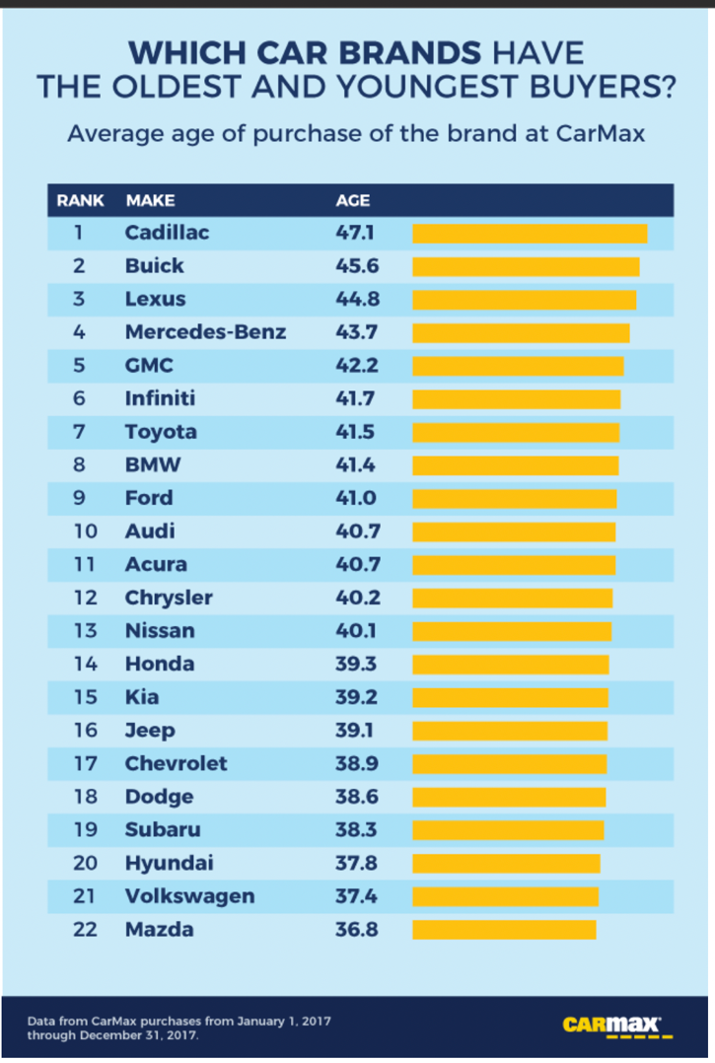

In [47]:
from IPython.display import Image
Image(filename=r'carmax.png', width=400, height=550)